In [123]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion',one_hot=True)


Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [124]:
data.train.labels

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

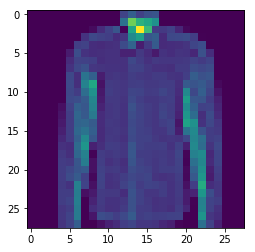

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
pixels = data.train.images[9].reshape((28, 28))
plt.imshow(pixels)
plt.show()

In [126]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 784])

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))


In [127]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [128]:
y_ = tf.placeholder(tf.float32, [None, 10])

In [129]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [130]:
# What should be the optimal learning rate
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [131]:
sess = tf.InteractiveSession()

In [132]:
tf.global_variables_initializer().run()

# Why batch size ? 

A convolutional neural network (CNN) doesn’t process its inputs one-at-a-time: to increase throughput, it will process the data in batches.

For CNNs that are trained on images, for example, say your dataset is RGB (3-channel) images that are 256x256 pixels. A single image can be represented by a 3 x 256 x 256 matrix. If you set your batch size to be 10, that means you’re concatenating 10 images together into a 10 x 3 x 256 x 256 matrix.

In practice, you’ll create batches of data that are randomly selected from your training set. This is the ‘stochastic’ part of stochastic gradient descent (SGD). During a single forward and backward pass of training, the network will update its parameters according to what’s in the batch. This is why the selection has to be random - if you feed in a batch of only dog images, the CNN will become a little more eager to classify images as dogs after that training iteration.

Tuning the batch size is one of the aspects of getting training right - if your batch size is too small, then there will be a lot of variance within a batch, and your training loss curve will bounce around a lot. But if it’s too large, your GPU will run out of memory to hold it, or training will progress too slowly to see if it’s the optimization is diverging early on.

I think you’ll also find the answers to this question helpful:

# Intuitively, how does mini-batch size affect the performance of (stochastic) gradient descent?

Algorithmically speaking, using larger mini-batches in SGD allows you to reduce the variance of your stochastic gradient updates (by taking the average of the gradients in the mini-batch), and this in turn allows you to take bigger step-sizes, which means the optimization algorithm will make progress faster. However, the amount of work done (in terms of number of gradient computations) to reach a certain accuracy in the objective will be the same: with a mini-batch size of n, the variance of the update direction will be reduced by a factor n, so the theory allows you to take step-sizes that are n times larger (see, e.g., [1, end of Section 4.2]), so that a single step will take you roughly to the same accuracy as n steps of SGD with a mini-batch size of 1.

This sounds like great news since it suggests that taking very large mini-batches will converge just as quickly in terms of gradient computations as using a single example at a time, which is great because computing the gradient on a large mini-batch is trivial to parallelize (on a GPU, multiple GPUs or even many machines), while using a single example per iteration requires synchronization after each example, which makes parallelization much more challenging.

So where's the catch? Well, even though we said that larger mini-batches allow you to use larger step-sizes, the step-size cannot exceed an algorithmic, problem-dependent upper bound which depends on the smoothness of the objective function (typically 1/L, where L is the Lipschitz constant of the "full" gradients), so that once you've reached this step-size, increasing the mini-batch size will no longer allow you to increase the step-size, which means the extra computation in computing more gradients will be wasted. As an aside, note that SGD with fixed mini-batch size typically needs smaller step-sizes near the optimum, and in that situation one could consider increasing the batch size instead of decreasing the step-sizes, for improved parallelism.

In practice, especially in the case of deep learning with GPUs, larger mini-batches are very attractive computationally. In addition to easy parallelism across processors/machines, they can give much better throughput, for example by making use of efficient data reuse during back-propagation (e.g. doing one matrix-matrix multiply is much more efficient than doing many matrix-vector multiplies, since the latter likely needs to reload matrix data in registers more often), and by wasting less time in data communication round-trips. For these reasons it is quite common in practice to pick batch-sizes that fully leverage the GPU (e.g. until the memory is filled up), and just choose the largest step-size that works well in practice after a few quick trials. If the choice of step-size turns out to be guided by the 1/L (smoothness) constraint, then the variance of the updates will probably be lower than needed, but that's fine since it just means we’ll be able to keep the step-size constant for a longer period of time.

Update (June 2017): Facebook managed to scale up this strategy, which they call “linear scaling rule”, to a mini-batch size of 8192 for training state-of-the-art CNNs on ImageNet (Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour). They achieved this by including an initial “warmup” phase to prevent optimization difficulties with large step-sizes in the first few epochs, and by ensuring minimal communication overhead.

[1] [1606.04838] Optimization Methods for Large-Scale Machine Learning

In [133]:
# why training in batches ? how many epochs ?
for _ in range(1000):
  batch_xs, batch_ys = data.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [134]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [135]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

In [136]:
print(sess.run(accuracy, feed_dict={x: data.test.images, y_: data.test.labels}))

0.7889
